# RNN

In [2]:
import math
import torch
from torch import nn
from torch.nn import functional as F
import dl2_torch as d2l
import numpy as np

d:\Anaconda3\envs\data_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 时序数据特性

自回归模型：使用变量序列的前k个数值来预测当前该变量的数值。  
预测下一个时间点效果会比较好， 但是随着预测步数的增多，之前预测结果的误差会作为模型的输入，导致误差累积使得结果愈加便宜真实值。  

## 2. 语言数据特性

### 2.1 分词模型（n-grams）
不同 n-grams 词元组具有相同的分布特性，服从Zipfian 定律  
$$n_i \propto \frac{1}{i^\alpha},$$
$$等价于 \log n_i = -\alpha \log i + c,$$
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408191559038.png" width='400px' >
</div>  
因此语言数据中会存在相应的内部结构，可以使用模型来捕捉。

### 2.2 词元概率平滑

为了解决某些词没有出现在数据集中而导致相应概率为0的问题。  
多种平滑方式，且相应公式不同。  
例如拉普拉斯平滑:  又叫加一平滑，它对分子划分的计数加1，分母加类别数，
例如，已知一维变量分布的采样结果，变量为A，A的取值有三种情况：a1，a2，a3，现有样本集（a1.a2，a1，a2，a3，a1，a1，a2)，采用拉晋拉斯平滑计算三种取值的概率
P(A=a1）=（4+1）/（8+3)=5/11
P(A=a2)=（3+1）/（8+3）=4/11
P(A=a3)=（1+1）/（8+3）=2/11

### 2.3 **语言**评价指标  
困惑度 Perplexity  
$$\exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right)  exp内部为整个文本序列的熵$$  
该指标最小为1，最大为无穷大，数值越小表明模型预测越精准，性能越好。

## 3. RNN

### 矩阵分块计算
$$ 隐藏层计算 \mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hh}}  + \mathbf{b}_\textrm{h}). $$
$$ 输出层计算 \mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{\textrm{hq}} + \mathbf{b}_\textrm{q}. $$  
隐藏层的两个输入可以通过**矩阵分块乘法**合并为两个大矩阵的乘积

In [17]:
X, W_xh = torch.randn(3, 1), torch.randn(1, 4)
H, W_hh = torch.randn(3, 4), torch.randn(4, 4)
torch.matmul(X, W_xh) + torch.matmul(H, W_hh) - torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0)) < 1e-5

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

### Backpropagation through time (BPTT)

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408202342607.png" width='500px' >
</div>  

RNN 网络的某个隐藏层$h_t$关于$w_h$的导数 ：  
$$ \frac{\partial h_t}{\partial w_\textrm{h}}= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}} +\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}. $$

将后面递归的部分展开来： $$ \frac{\partial h_t}{\partial w_\textrm{h}}=\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t} \frac{\partial f(x_{j},h_{j-1},w_\textrm{h})}{\partial h_{j-1}} \right) \frac{\partial f(x_{i},h_{i-1},w_\textrm{h})}{\partial w_\textrm{h}}.$$

将计算图中符号带入具体计算结果,推导见[reference](https://d2l.ai/chapter_recurrent-neural-networks/bptt.html)。

$$ \frac{\partial L}{\partial \mathbf{h}_t}= \sum_{i=t}^T {\left(\mathbf{W}_\textrm{hh}^\top\right)}^{T-i} \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_{T+t-i}}. $$

$$ \begin{split}\begin{aligned}
\frac{\partial L}{\partial \mathbf{W}_\textrm{hx}}
&= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_\textrm{hx}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{x}_t^\top,\\
\frac{\partial L}{\partial \mathbf{W}_\textrm{hh}}
&= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_\textrm{hh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{h}_{t-1}^\top,
\end{aligned}\end{split}$$  

**总结：实际计算参数梯度时不会计算所有时间步的梯度，用截断（常规截断或随机截断）的方法计算固定时间步梯度。**  

other : 对于一个随机向量，$ \mathbf{M}^k \mathbf{x} $ 的结果会逐渐对其 $\mathbf{M}$​ 的一个特征向量 。

### 手动实现

In [18]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        if state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            state = torch.zeros((inputs.shape[1], self.num_hiddens),
                            device=inputs.device)
        else:
            state, = state
        outputs = []
        for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
            state = torch.tanh(torch.matmul(X, self.W_xh) +
                            torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state

In [19]:
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)  # torch.stack([(batch, feature)], axis=1) 得到的结果为 batch, seq, feature

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])  # RNN 的损失函数为所预测时间步字符的概率分布与真实字符概率分布的cross_entropy (每个时间步的预测输出与真实值即下一个字符的cross_entropy)
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def forward(self, X, state=None):
        embs = self.one_hot(X)
        print(X.shape, embs.shape)
        rnn_outputs, _ = self.rnn(embs, state)
        print(rnn_outputs.shape)
        return self.output_layer(rnn_outputs)
    
    #  预测下一个字符
    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

In [20]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))

torch.Size([2, 100]) torch.Size([100, 2, 16])


AttributeError: 'list' object has no attribute 'shape'

#### 梯度裁剪

如果梯度的模大于阈值，则将其调整至阈值内  
$$ \mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}。 $$

In [ ]:
def clip_gradients(grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

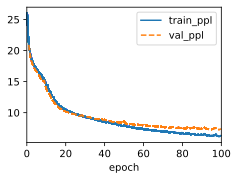

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has of the time travell'

## 4. 门控网络

### 4.1 LSTM
1. 为何LSTM的隐藏层输出需要使用tanh激活调整为 -1，1 ？  
在 LSTM（长短期记忆网络）中，候选记忆单元和隐藏状态都使用了 tanh 函数，但它们的作用不同。  
通过 tanh 将候选记忆单元（改单元数值会直接加入到记忆单元中，因此需要保持数值在一定范围内）限制在 -1，1 ，防止值过大在训练中保持稳定。  在使用 tanh(Ct) 计算隐藏状态时可以如此考虑。

2. LSTM 如何缓解梯度消失及梯度爆炸？  记忆单元的short cut  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408220946145.png" width='500px' >
</div>

In [ ]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

    def forward(self, inputs, H_C=None):
        if H_C is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                        device=inputs.device)
            C = torch.zeros((inputs.shape[1], self.num_hiddens),
                        device=inputs.device)
        else:
            H, C = H_C
        outputs = []
        for X in inputs:
            I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                            torch.matmul(H, self.W_hi) + self.b_i)
            F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                            torch.matmul(H, self.W_hf) + self.b_f)
            O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                            torch.matmul(H, self.W_ho) + self.b_o)
            C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                            torch.matmul(H, self.W_hc) + self.b_c)
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H)
        return outputs, (H, C)

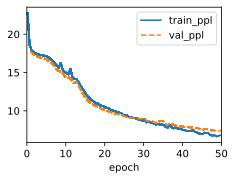

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

### 4.2 GRU

GRU 包含一个隐藏状态 H 及 2个门控制单元。  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408212122207.png" width='500px' >
</div>

具体计算公式如下：

$$\begin{split}\begin{aligned}
重置门 \mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xr}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hr}} + \mathbf{b}_\textrm{r}),\\
更新门 \mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xz}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hz}} + \mathbf{b}_\textrm{z}),\\
候选隐藏状态 \tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{\textrm{hh}} + \mathbf{b}_\textrm{h}),\\ 输出隐藏状态\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.\end{aligned}\end{split}  $$

候选隐藏状态计算公式中，若重置门 $\mathbf{R}_t $  接近1，则$ \tilde{\mathbf{H}}_t $ 计算结果与普通RNN(vanilla RNN)相同， 接近0，则为MLP，任何预先存在的隐藏状态都会被*重置*为默认值。

- 重置门有助于捕获序列中的短期依赖关系。
- 更新门有助于捕获序列中的长期依赖关系。

In [ ]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

    def forward(self, inputs, H=None):
        if H is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                        device=inputs.device)
        outputs = []
        for X in inputs:
            Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                            torch.matmul(H, self.W_hz) + self.b_z)
            R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                            torch.matmul(H, self.W_hr) + self.b_r)
            H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                            torch.matmul(R * H, self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_tilde
            outputs.append(H)
        return outputs, H

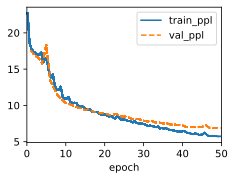

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

### 4.3 多层叠加  
深度RNN扩展：将单层RNN的输出序列作为下一层RNN的输入，方便计算。

In [ ]:
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = nn.Sequential(*[d2l.RNNScratch(
            num_inputs if i==0 else num_hiddens, num_hiddens, sigma)
                                    for i in range(num_layers)])
        
    def forward(self, inputs, Hs=None):
        outputs = inputs
        if Hs is None: Hs = [None] * self.num_layers
        for i in range(self.num_layers):
            outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
            outputs = torch.stack(outputs, 0)
        return outputs, Hs

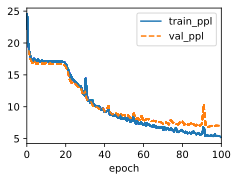

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn_block = StackedRNNScratch(num_inputs=len(data.vocab),
                              num_hiddens=32, num_layers=2)
model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

### 4.4 双向 

双向RNN实现：创建两个RNN，将一个输入反向后计算RNN的输出，将反向层输出再反向后与正向计算结果按照时间步对应拼接。  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408221005904.png" width='500px' >
</div>

In [ ]:
class BiRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.f_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        self.b_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        self.num_hiddens *= 2  # The output dimension will be doubled  
    
    def forward(self, inputs, Hs=None):
        f_H, b_H = Hs if Hs is not None else (None, None)
        f_outputs, f_H = self.f_rnn(inputs, f_H)
        b_outputs, b_H = self.b_rnn(reversed(inputs), b_H)
        outputs = [torch.cat((f, b), -1) for f, b in zip(
            f_outputs, reversed(b_outputs))]
        return outputs, (f_H, b_H)

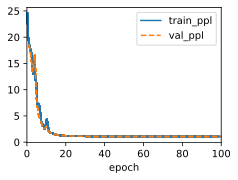

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn_block = BiRNNScratch(num_inputs=len(data.vocab),
                              num_hiddens=32)
model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

# Language Translation

## 1. 数据集准备

创建本文数据 batch 的时候，可以考虑将不同序列长度的数据集分组，使得相似长度的数据在同一个batch里面，减少在batch上的运算。  
数据集：  https://www.manythings.org/anki/  

In [3]:
class MTFraEng(d2l.DataModule):
    """The English-French dataset."""
    def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
        super(MTFraEng, self).__init__()
        self.save_hyperparameters()
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
            self._download())

    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()
        
    #  预处理
    def _preprocess(self, text):
        # 将窄不换行空格 \u202f 替换为普通的空格 \xa0
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        # 将文本处理成小写字母，并且将紧挨字符的标点前加入空格。
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
            for i, char in enumerate(text.lower())]
        return ''.join(out)
    
    #  tokenization
    def _tokenize(self, text, max_examples=None):
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            if max_examples and i > max_examples: break
            parts = line.split('\t')
            if len(parts) == 2:
                # 略过空的 token
                src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
                tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
        return src, tgt
    
    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        def _build_array(sentences, vocab, is_tgt=False):
            #  裁剪或者填充序列至相同的长度
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences]
            if vocab is None:
                vocab = d2l.Vocab(sentences, min_freq=2)
            array = torch.tensor([vocab[s] for s in sentences])
            valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
            return array, vocab, valid_len
        src, tgt = self._tokenize(self._preprocess(raw_text),
                                self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
                src_vocab, tgt_vocab)
    
    def get_dataloader(self, train):
        #  返回包含 原始token, encode输入， 原始序列长度， label 的数据集
        #  slice 创建切片所需的索引
        idx = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader(self.arrays, train, idx)

    def build(self, src_sentences, tgt_sentences, raw_text=None):
        if raw_text is None:
            raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
            src_sentences, tgt_sentences)])
        arrays, _, _ = self._build_arrays(
            raw_text, self.src_vocab, self.tgt_vocab)
        return arrays
    

In [4]:
batch_size = 2
data = MTFraEng(batch_size)
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print('source:', src.type(torch.int32))
print('decoder input:', tgt.type(torch.int32))
print('source len excluding pad:', src_valid_len.type(torch.int32))
print('label:', label.type(torch.int32))

source: tensor([[ 12,   0,   3,   4,   4,   4,   4,   4,   4],
        [ 16, 153,   2,   3,   4,   4,   4,   4,   4]], dtype=torch.int32)
decoder input: tensor([[  3,   6,   0,   4,   5,   5,   5,   5,   5],
        [  3, 179,  38,   0,   4,   5,   5,   5,   5]], dtype=torch.int32)
source len excluding pad: tensor([3, 4], dtype=torch.int32)
label: tensor([[  6,   0,   4,   5,   5,   5,   5,   5,   5],
        [179,  38,   0,   4,   5,   5,   5,   5,   5]], dtype=torch.int32)


['hang', 'on', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

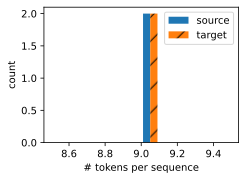

In [5]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    #  绘制每个句子token长度的图片
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence','count', src, tgt)
#  将seq转换为
def token_2_language(seq, dataclass, is_src=True):
    if is_src:
        return dataclass.src_vocab.to_tokens(seq.type(torch.int32))
    else:
        return dataclass.tgt_vocab.to_tokens(seq.type(torch.int32))

token_2_language(torch.Tensor([ 64, 122,   0,   3,   4,   4,   4,   4,   4]), data)

## 2.Seq2Seq

In [5]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
import dl2_torch as d2l

In [42]:
emb = nn.Embedding(5,3)
test = torch.range(0,3).reshape(2,2).type(torch.int32)
# Embedding 层的输入为batch_size * step, 每个step为token的编号，输出为token对应的embedding
torch.stack((emb.weight[:2], emb.weight[2:4])) == emb(test)  

d:\Anaconda3\envs\data_torch\lib\site-packages\ipykernel_launcher.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  


tensor([[[True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True]]])


<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408222020538.png" width='600px' >
</div>

### 模型参数初始化 及 Encoder

In [60]:
def init_seq2seq(module):
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    # if type(module) == nn.GRU:
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:  # 根据参数的名称选取对应参数进行初始化
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers = num_layers, dropout=dropout)
        self.apply(init_seq2seq)  # self 即nn.module实例， 可以用apply方法初始化参数

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)  即模型最后每个时间步在最后一层的输出
        # state shape: (num_layers, batch_size, num_hiddens)  即所有层在最后一个时间步的输出
        return outputs, state

In [52]:
#  测试
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))

### Decoder
关键点：  
1. 编码器最后一个时间步的输出作为上下文变量，并将这个变量与decoder的每个时间步的输入进行合并作为decoder的最终输入。  
2. 训练时self.rnn的首个隐藏状态是encoder输出的隐藏状态，在推理时由于每次仅预测一个时间步，因此上一个时间步的hidden会作为这个时间步推理的hidden输入。

In [61]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
        #                    num_layers, dropout)
        self.rnn = nn.LSTM(embed_size+num_hiddens, num_hiddens,
                           num_layers = num_layers, dropout = dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)  # 此处用了encoder输出的hidden
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

### Seq2Seq
关键点：  
1. loss 的实现使用 mask 将 target 中为 pad 填充部分的损失给消除掉，填充标记的预测应该排除在损失计算之外。

In [62]:
class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()
    
    def loss(self, Y_hat, Y):  # 注意loss
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()
    
    # def loss(self, Y_hat, Y):  # 注意loss
    #     l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=True)  # averaged = False 表示按照label的维度计算loss，即每个时间步的token与预测的分布向量计算交叉熵
    #     return l

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    # def training_step(self, batch):  # 测试decoder不使用老师teacher force，使用前一个时间步的输出作为下一个时间步输入
    #     y_hat = self.train_predict_step(batch, d2l.try_gpu(), num_steps=9)
    #     # print(y_hat.shape)
    #     # print(batch[-1].shape)
    #     l = self.loss(y_hat, batch[-1])
    #     self.plot('loss', l, train=True)
    #     return l

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
# 与 teacher force 实验代码配套
# @d2l.add_to_class(Seq2Seq)
# def train_predict_step(self, batch, device, num_steps):
#     batch = [a.to(device) for a in batch]
#     src, tgt, src_valid_len, _ = batch
#     enc_all_outputs = self.encoder(src, src_valid_len)
#     dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
#     outputs = [tgt[:, (0)].unsqueeze(1), ]
#     train_pred = []
#     for _ in range(num_steps):
#         Y, dec_state = self.decoder(outputs[-1], dec_state)
#         train_pred.append(Y)
#         outputs.append(Y.argmax(2))
#         # Save attention weights (to be covered later)
#     # print(len(train_pred), train_pred[0].shape)
#     train_pred = torch.concat(train_pred, axis=1)
#     # print(train_pred.shape)
#     return train_pred

### Train
关键点：  
1. 使用teacher forcing的方式处理decoder input，即**训练**时候decoder每个时间步的输入都是目标序列，而**预测**时后面时间步的输入是上个时间步的预测。

In [55]:
class seq2seq_train(d2l.Trainer):
    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
        total_l = 0
        batch_s = 0
        for batch in self.val_dataloader:
            with torch.no_grad():
                b = self.prepare_batch(batch)
                total_l += self.model.loss(self.model(*b[:-1]), b[-1])
                batch_s += 1
        print('final_loss', total_l / batch_s)

final_loss tensor(3.0972, device='cuda:0')


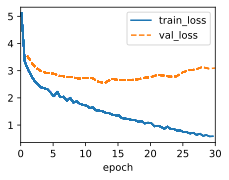

In [63]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = seq2seq_train(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

### 推理
关键点：  
1. 开始时将数据变为batchsize， 1 step 的格式，此时每个batch的数据均为 < bos>   
2. 预测时后面时间步的输入是上个时间步的预测, 且encoder的context 向量在dec_state变量中保持不变，在后续每个时间步推理的时候都用上。

In [64]:
@d2l.add_to_class(Seq2Seq)
def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights

#### BLEU评价指标   
A B C D E F 与 A B B C D 的p1=4/5, p2=3/4, p3=1/3 , pn表示n-gram， 将k-gram指标加权相乘即为 BLEU， 最大为1。
$$ \exp\left(\min\left(0, 1 - \frac{\textrm{len}_{\textrm{label}}}{\textrm{len}_{\textrm{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},  $$  
1. k-gram越长的pk权重越高， 2.预测序列长度过短则通过 exp 进行降分。

In [65]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [66]:
# engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
# fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

data = MTFraEng(128)
test_data = data._download()
test_list = test_data.split('\n')[:640]
test_batch_data = data.build(None, None, ('\n').join(test_list))

preds, _ = model.predict_step(
    test_batch_data, d2l.try_gpu(), data.num_steps)

src, tgt = data._tokenize(data._preprocess(('\n').join(test_list)))
total_score = []
for en, fr, p in zip(src, tgt, preds):
    fr = ' '.join(fr[:-1])
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    total_score.append(bleu(" ".join(translation), fr, k=2))
    # print(f'{en} => {translation}, bleu,'
    #       f'{bleu(" ".join(translation), fr, k=2):.3f}')
print('mean bleu', np.mean(total_score))

mean bleu 0.20810679180605923


### 实验

1. 在损失计算中不使用掩码。你观察到了什么结果？  
不使用mask，计算所得的loss会更多，因为loss使用均值计算，而 pad 没有意义的token容易预测准确，该token处的值较小，导致整个loss平均后偏小。  
使用mask, loss 3.6 BLEU 0.354  , 不使用mask  loss 1.6 BLEU 0.350   
总体来看使用mask更好

2. 在训练中，用将前一个时间步的预测输入解码器来代替教师强制。这会对性能产生什么影响？
整体loss上升变为 3.9  BLEU下降为 0.329， 性能变差

3. 用 LSTM 替换 GRU 来重新运行实验
loss 变小为 2.77； BLEU 变差，为0.207

### Beam Search

贪心搜索，穷举搜索，束搜索，示例代码使用的是贪心搜索。  
[beam search](https://d2l.ai/chapter_recurrent-modern/beam-search.html)：  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408242243154.png" width='600px' >
</div>

k束搜索：每个时间步都选出概率最大的k个预测目标，例如 A,C 是第一个时间步最大的两个， AB CE是 10个第二步序列中最大的两个。  
选出的6个序列 （总共为kT，T为预测序列长度），经过 eos 截断处理后，再通过计算下式选择最优序列。  
$$ \frac{1}{L^\alpha} \log P(y_1, \ldots, y_{L}\mid \mathbf{c}) = \frac{1}{L^\alpha} \sum_{t'=1}^L \log P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c}); $$  
L为序列长度， alpha通常选 为 0.75  
由于log 概率为负数，通过$\frac{1}{L^\alpha}$增加其得分,L 越长该系数越小，负值调整变得越大。鼓励生成长的语句